In [8]:
import os
import pickle
import itertools
from math import log2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import ks_2samp

import umap.umap_ as umap
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textwrap import wrap
# import seaborn as sns

In [3]:
def save_obj(obj:object,name:str):
    ext = '.pickle'
    with open(name + ext, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(name:str)->object:
    ext = '.pickle'
    with open(name + ext, 'rb') as handle:
        return pickle.load(handle)

In [4]:
train_path = "train.tsv"
df = pd.read_csv(train_path, sep="\t")
df.head()

,Id,EssaySet,Score1,Score2,EssayText
0,1,1,1,1,Some additional information that we would need...
1,2,1,1,1,"After reading the expirement, I realized that ..."
2,3,1,1,1,"What you need is more trials, a control set up..."
3,4,1,0,0,The student should list what rock is better an...
4,5,1,2,2,For the students to be able to make a replicat...


## check for null answers

In [6]:
queries = ["<Not applicable>","Null", None, "unavailable", "not applicable", "not available",""," "]
for q in queries:
    print(df[df.EssayText == q].shape[0])

0
0
0
0
0
0
0
0


In [7]:
df.Score1.value_counts()

0    6779
1    5612
2    4075
3     741
Name: Score1, dtype: int64

In [ ]:
socre1 , socre2, essays= [], [], []

for i in range(10):
    key = "essay_" + str(i+1)
    ess_emb[key] = df.query("EssaySet == {}".format(i+1)).EssayText.values

In [19]:
df.Score1.value_counts().values

[6779, 5612, 4075, 741]

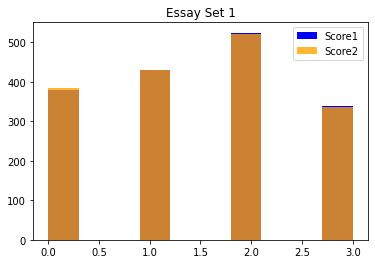

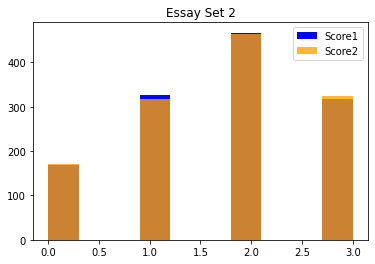

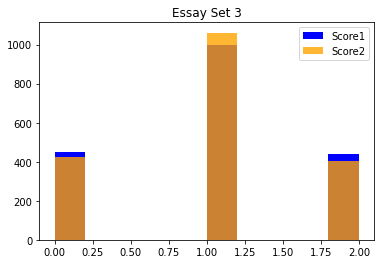

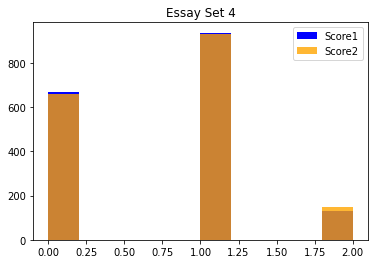

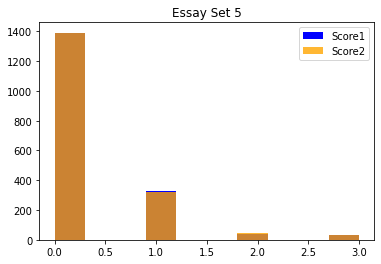

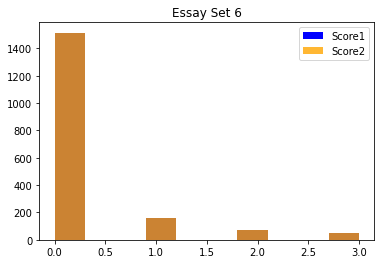

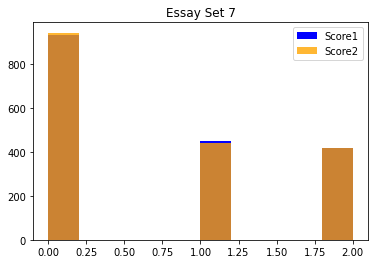

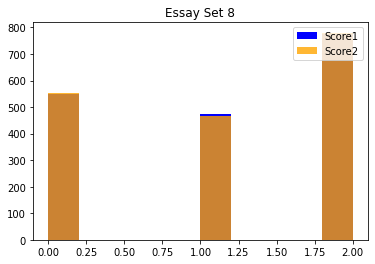

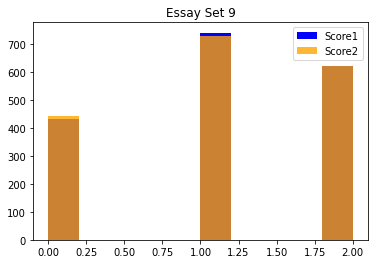

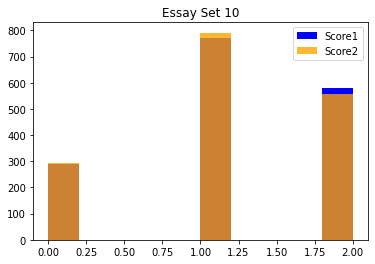

In [57]:
# plot the distribution of scores for each essay set
score1 , score2, essays= [], [], []
score1_p , score2_p= [], []
for i in range(10):
    q = df.query("EssaySet == {}".format(i+1))
    score1.append(q.Score1.values)
    score2.append(q.Score2.values)
    
    # probability of each score
    temp = q.Score1.value_counts().values
    temp = temp / sum(temp)
    score1_p.append(temp.tolist())
    temp = q.Score2.value_counts().values
    temp = temp / sum(temp)
    score2_p.append(temp.tolist())
    
    essays.append(q.EssayText.values)
    plt.hist(score1[i], bins=10, alpha=1, label="Score1", color="blue")
    plt.hist(score2[i], bins=10, alpha=0.8, label="Score2", color="orange")
    plt.legend(loc='upper right')
    plt.title("Essay Set {}".format(i+1))
    plt.show()

> seems that they agreed on most of the grades

**on overall grades**

((-0.5, 3.5, 0.0, 7117.95), (-0.5, 3.5, 0.0, 7119.0))

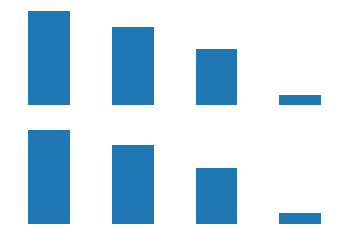

In [59]:
fig , ax = plt.subplots(2)
df.Score1.value_counts().plot(kind="bar",ax=ax[0]) 
df.Score2.value_counts().plot(kind="bar",ax=ax[1])
ax[0].axis(False), ax[1].axis(False)

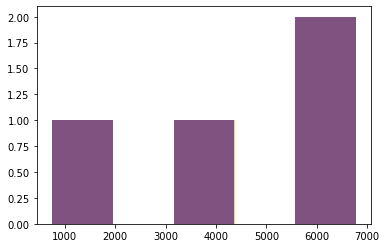

In [55]:
plt.hist(df.Score1.value_counts(), bins=5, label="Score1", color="blue");
plt.hist(df.Score2.value_counts(), bins=5, label="Score1", alpha =0.5, color="orange");

almost identical distribution from both graders

#### discrete KS test

In [62]:
def list_flatten(lst: list) -> list:
    return list(itertools.chain.from_iterable(lst))

In [67]:
#perform Kolmogorov-Smirnov test
ks_2samp(np.array(list_flatten(score1)).ravel(), np.array(list_flatten(score2)).ravel())

KstestResult(statistic=0.002150287673621243, pvalue=0.9999999999992726)

#### for more accuracy try the kl_divergence

In [41]:
def kl_divergence(p, q):
	return round(sum(p[i] * log2(p[i]/q[i]) for i in range(len(p))),5)

# calculate the kl divergence for each essay set
for i in range(10):
	print(f"For essay Set {i+1}  kl: {kl_divergence(socre1_p[i], socre2_p[i])}")
	# one is enough
	# print("Score2: {}".format(kl_divergence(socre2_p[i], socre1_p[i])))

For essay Set 1  kl: 4e-05
For essay Set 2  kl: 7e-05
For essay Set 3  kl: 0.00321
For essay Set 4  kl: 0.00103
For essay Set 5  kl: 0.00039
For essay Set 6  kl: 0.0
For essay Set 7  kl: 0.0001
For essay Set 8  kl: 6e-05
For essay Set 9  kl: 0.00018
For essay Set 10  kl: 0.00076


In [47]:
# for overall kl divergence
# flatten the list of lists
print(f"""KL(socre1_p || socre2_p): {kl_divergence(list(itertools.chain.from_iterable(socre1_p)),
            list(itertools.chain.from_iterable(socre2_p)))}""")

KL(socre1_p || socre2_p): 0.00585


## umap and emb

In [18]:
MODELPATH = 'xlm-r-distilroberta-base-paraphrase-v1'
model = SentenceTransformer(MODELPATH)

In [25]:
ess_emb = {}
for i in range(10):
    key = "essay_" + str(i+1)
    ess_emb[key] = model.encode(df.query("EssaySet == {}".format(i+1)).EssayText.values)

In [45]:
save_obj(ess_emb, 'ess_emb')

In [47]:
ess_emb = load_obj('ess_emb')
ess_emb["essay_1"].shape

(1672, 768)

In [35]:
fit = umap.UMAP(n_neighbors=5, min_dist=0.03, n_components=3).fit_transform(ess_emb["essay_1"])

In [38]:
fig = px.scatter_3d(fit, x=fit[:,0], y=fit[:,1], z=fit[:,2], 
    color=df[df.EssaySet==1].Score1.values)
fig.show()

In [39]:
fit = umap.UMAP(n_neighbors=4, min_dist=0.03, n_components=3).fit_transform(ess_emb["essay_1"])

fig = px.scatter_3d(fit, x=fit[:,0], y=fit[:,1], z=fit[:,2], 
    color=df[df.EssaySet==1].Score1.values)
fig.show()

In [40]:
fit = umap.UMAP(n_neighbors=4, min_dist=0.03, n_components=2).fit_transform(ess_emb["essay_1"])

fig = px.scatter(fit, x=fit[:,0], y=fit[:,1], 
    color=df[df.EssaySet==1].Score1.values)
fig.show()

In [43]:
fit = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2).fit_transform(ess_emb["essay_1"])

fig = px.scatter(fit, x=fit[:,0], y=fit[:,1], 
    color=df[df.EssaySet==1].Score1.values)
fig.show()

In [42]:
fit = umap.UMAP(n_neighbors=3, min_dist=0.03, n_components=2).fit_transform(ess_emb["essay_1"])

fig = px.scatter(fit, x=fit[:,0], y=fit[:,1], 
    color=df[df.EssaySet==1].Score1.values)
fig.show()

# visualize main keywords in each essay

In [7]:
def wordcloud(data,title):
    data = WordCloud().process_text(data)
    wc = WordCloud(colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()

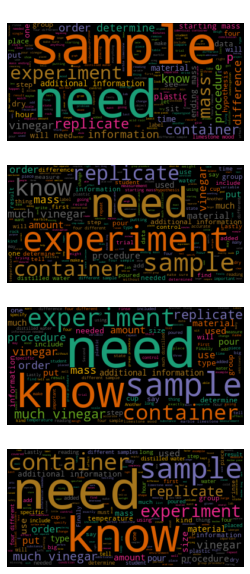

In [19]:
# draw 3 wordclouds for essay set 1
# plot 3 horizontal wordclouds
fig, ax = plt.subplots(4, 1, figsize=(10,10))
for i in range(4):
    title = f"Scores = {i}"
    essays = " ".join(cat for cat in df.query(f"EssaySet == {1} and Score1 == Score2 and Score1 == {i}").EssayText.sort_values(ascending=False).values)
    # wordcloud(essays,title)
    data = WordCloud().process_text(essays)
    wc = WordCloud(colormap="Dark2").generate_from_frequencies(data)
    ax[i].imshow(wc, interpolation='bilinear')
    ax[i].axis("off")
    ax[i].set_title('\n'.join(wrap(title,60)),fontsize=13,color='white')

# save the figure
fig.savefig("wordcloud_essay_set_1.png")

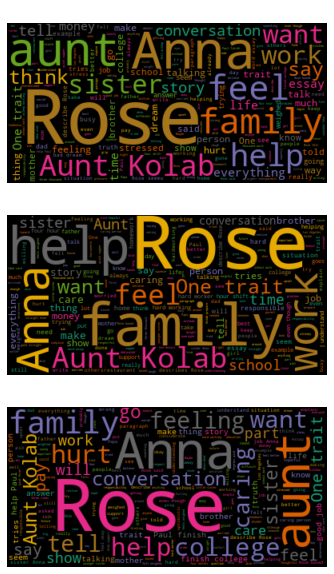

In [20]:
# the same for essay set 7
fig, ax = plt.subplots(3, 1, figsize=(10,10))
for i in range(3):
    title = f"Scores = {i}"
    essays = " ".join(cat for cat in df.query(f"EssaySet == {7} and Score1 == Score2 and Score1 == {i}").EssayText.sort_values(ascending=False).values)
    # wordcloud(essays,title)
    data = WordCloud().process_text(essays)
    wc = WordCloud(colormap="Dark2").generate_from_frequencies(data)
    ax[i].imshow(wc, interpolation='bilinear')
    ax[i].axis("off")
    ax[i].set_title('\n'.join(wrap(title,60)),fontsize=13,color='white')

# save the figure
fig.savefig(f"wordcloud_essay_set_{7}.png")

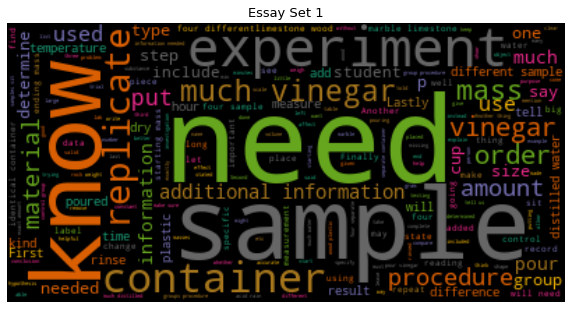

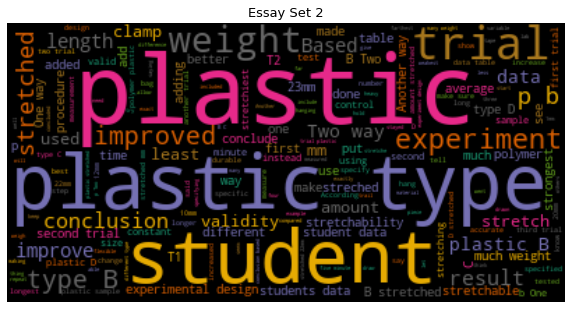

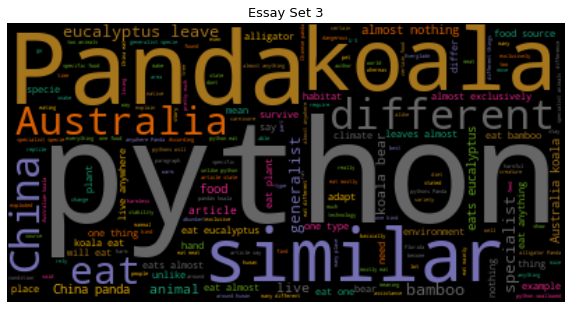

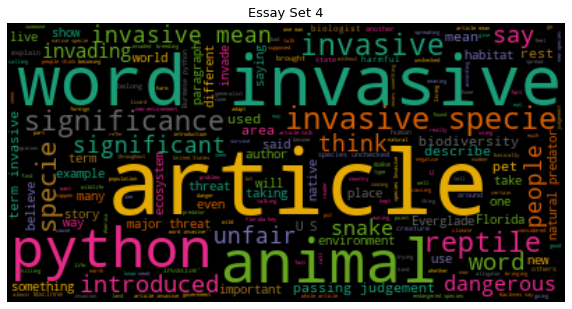

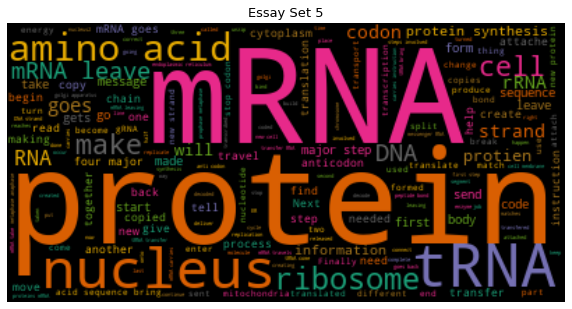

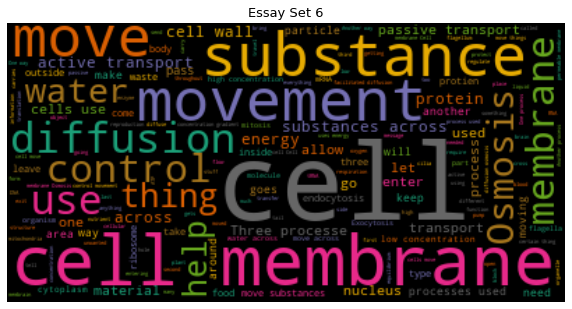

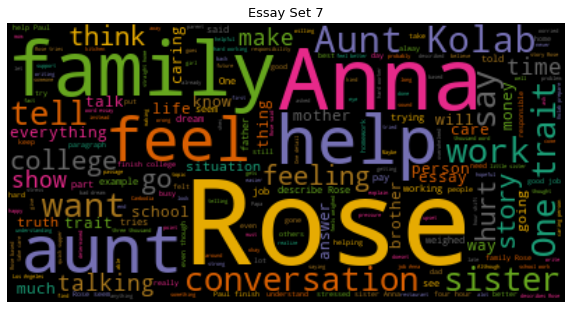

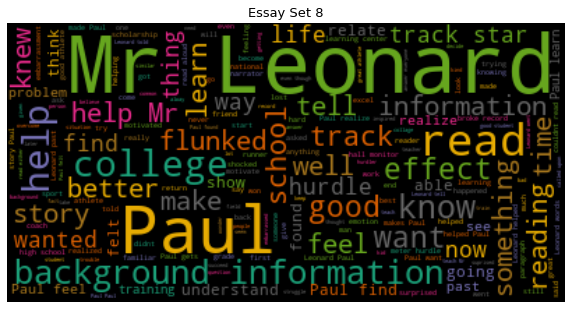

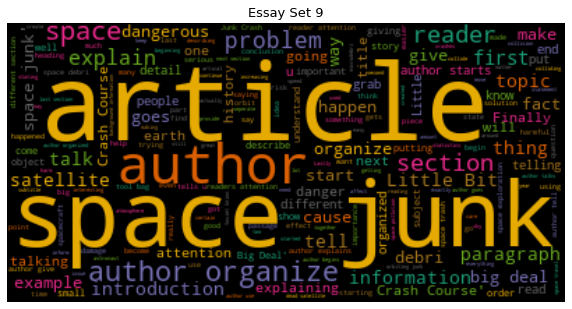

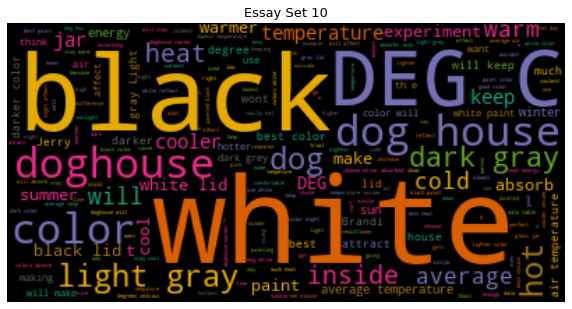

In [128]:
for i in range(10):
    title = f"Essay Set {i+1}"
    essays = " ".join(cat for cat in df.query(f"EssaySet == {i+1}").EssayText.sort_values(ascending=False).values)
    wordcloud(essays,title)

In [7]:
first_Essay_set = df.query("EssaySet == 1")
first_Essay_set_right_Answers = first_Essay_set.query("Score1 == 3 and Score2 == 3")
first_Essay_set_right_Answers.head()

,Id,EssaySet,Score1,Score2,EssayText
7,8,1,3,3,You would need many more pieces of information...
8,9,1,3,3,Some additional information you will need are ...
11,12,1,3,3,The additional infomation you would need to re...
16,17,1,3,3,"In order to replicate this experiment, I would..."
19,20,1,3,3,In order for the me to replicate their procedu...


In [31]:
os.makedirs("data/first_essay_set", exist_ok=True)

first_Essay_set_right_Answers.to_csv("data/first_essay_set/right_answers.csv")
first_Essay_set.to_csv("data/first_essay_set/answers.csv")

In [8]:
f = first_Essay_set_right_Answers["EssayText"][:20]
out =[i for i in f]
out[:2]

['You would need many more pieces of information to replicate the experiment. You would need the type of samples to begin with in the procedure. You would also need to know the amount of vinegar used in each container. You would also need to know exactly how to mass the samples and what types of container to use (plastic for example, might alter the results).',
 'Some additional information you will need are the material. You also need to know the size of the contaneir to measure how the acid rain effected it. You need to know how much vineager is used for each sample. Another thing that would help is to know how big the sample stones are by measureing  the best possible way.']

In [34]:
first_right_Answers = pd.read_csv("data/first_essay_set/right_answers.csv")["EssayText"]
first_right_Answers[:10]

0    You would need many more pieces of information...
1    Some additional information you will need are ...
2    The additional infomation you would need to re...
3    In order to replicate this experiment, I would...
4    In order for the me to replicate their procedu...
5    For this experiments duplication, you would ne...
6    In order to replicate this experiment, you wou...
7    For this experiment, you would actually need t...
8    To replicate the experiment I would need to kn...
9    In order to replicate this experiment:you woul...
Name: EssayText, dtype: object

In [35]:
outs = BERT.model.encode(first_right_Answers)
outs.shape

(302, 768)

In [36]:
model_answer_mean = np.mean(outs, axis=0)
model_answer_median = np.median(outs, axis=0)

In [37]:
from sentence_transformers.util import cos_sim

In [40]:
cos_sim(BERT.model.encode(e),model_answer_median),cos_sim(BERT.model.encode(e),model_answer_mean)

(tensor([[0.5253]]), tensor([[0.5289]]))

In [26]:
cos_sim(model_answer_mean,model_answer_median)

tensor([[0.9994]])

In [17]:
preds = cos_sim(outs,model_answer)
np.sum(np.array(preds) > 0.7)

280

In [ ]:
# batch predictection over df
def batch_predict(df, model, batch_size=100):
    sim_preds = []
    ner_preds = []
    keywords_preds = []
    for i in range(0, len(df), batch_size):
        keywords, ner, sim=model.predict(df.iloc[i:i+batch_size])
        sim_preds.append(sim)
        ner_preds.append(ner)
        keywords_preds.append(keywords)
    # return np.concatenate(preds)
    return np.concatenate(sim_preds), np.concatenate(ner_preds), np.concatenate(keywords_preds)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
def vectorize(Text):
    return TfidfVectorizer().fit_transform(Text).toarray()
def similarity(doc1, doc2):
    return cosine_similarity([doc1, doc2])

In [23]:
student_files = list(first.index)
student_notes = list(first.values)

In [25]:
student_notes[10] , student_files[10]

('After reading the procedure i would  first need to know what the for sample are that i am testing second i ^p would need to know how much vinegar put in each container next the procedure should tell me how thing to case rinse each sample in distiled water.',
 10)